In [1]:
# Importando Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Abrindo um arquivo CSV com o Pandas
df = pd.read_csv("qualidade_do_ar.csv", encoding = "UTF-8", sep = ";", header = 0, na_values=-200)
df.dtypes

Date              object
Time              object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
dtype: object

# Tratamento de Valores Faltantes
A Estratégia adotada para o tratamento do valores faltantes foi a exclusão destes valores. A coluna 'NMHC(GT)' tinha cerca de 20% dos dados, optei por exclui-lá. Não poderia completar tantos dados.
Para as outras colunas, eliminei apenas as linhas que continham o NaN. Excetuando as colunas 'NOx(GT)' e 'NO2(GT)' foram as colunas que mais apresentavam NaN. Foram excluídos cerca de 18% dos dados originais. O novo dataset está em 'new_dataset.csv'

In [3]:
# Deletando a coluna NMHC(GT), grande parte dos dados é NaN.
df.drop('NMHC(GT)', axis = 1, inplace = True)
df.dropna(how = 'any', inplace = True)

# Convertendo as Séries de String para o tipo adequado para trabalhar
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
df['Time'] = pd.to_datetime(df['Time'], format = '%H.%M.%S').dt.hour
for head in ['T', 'C6H6(GT)', 'RH', 'AH']:
        df[head] = pd.to_numeric(df[head].apply(lambda x: x.replace(',', '.')))

In [4]:
df['T'] = pd.to_numeric(df['T'].apply(lambda x: x.replace(',', '.')))
df['C6H6(GT)'] = pd.to_numeric(df['C6H6(GT)'].apply(lambda x: x.replace(',', '.')))
df['RH'] = pd.to_numeric(df['RH'].apply(lambda x: x.replace(',', '.')))
df['AH'] = pd.to_numeric(df['AH'].apply(lambda x: x.replace(',', '.')))

AttributeError: 'float' object has no attribute 'replace'

In [4]:
# Extraindo todos os dados de todas as Quarta-Feiras

wedDataFrame = df.loc[df['Date'].dt.dayofweek == 2, ['Time', 'PT08.S1(CO)']]

# Separando os dados por hora e fazendo a média. Tentei normalizar (np.linalg.norm()) mas os pontos ficavam mais alto que os valores. 

dadosNorm = []
hours = [i for i in range(0, 24)]
for hour in range(0, 24):
    hourSeries = wedDataFrame.loc[wedDataFrame['Time'] == hour, 'PT08.S1(CO)']
    dadosNorm.append(hourSeries.mean())

In [62]:
#wedDataFrame.loc[wedDataFrame['PT08.S1(CO)'] > 2000, ['Time', 'PT08.S1(CO)']]

,Time,PT08.S1(CO)


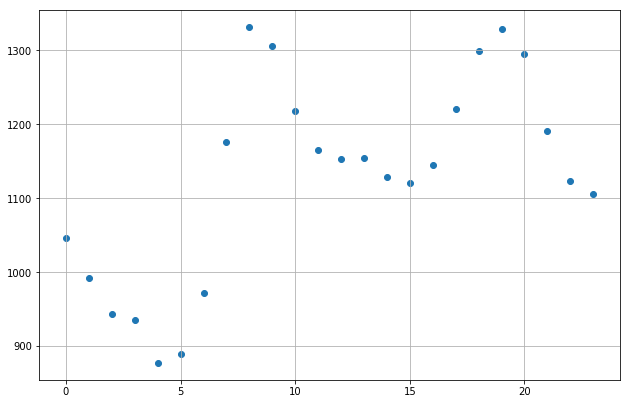

In [5]:
# Plot do Gráfico

plt.figure(figsize = [10.4, 6.8])
plt.scatter(hours, dadosNorm)
plt.grid(True, which='both')

#plt.scatter(wedDataFrame['Time'], wedDataFrame['PT08.S1(CO)'])

Pelo Gráfico, podemos ver que os horários são 8:00 e às 19:00.

In [14]:
# Calculando as Correlações da Variáveis com PT08.S1(CO).

correlacao = df.corr()
correlacao['PT08.S1(CO)']

PT08.S1(CO)      1.000000
NMHC(GT)         0.790670
PT08.S2(NMHC)    0.892964
NOx(GT)          0.713654
PT08.S3(NOx)    -0.771938
NO2(GT)          0.641529
PT08.S4(NO2)     0.682881
PT08.S5(O3)      0.899324
Name: PT08.S1(CO), dtype: float64

 'PT08.S5(O3)' e 'PT08.S2(NMHC)' têm uma forte correlação com 'PT08.S1(CO)'

# Uma tentativa de implementação de um modelo de Regressão Linear

In [16]:
# Importando as bibliotecas

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Definindo as variáveis independentes
LRDataFrame = df.drop(['Date','Time','T', 'RH', 'AH'], axis=1)
X = df.drop('PT08.S1(CO)', axis=1)
y = df[['PT08.S1(CO)']]

# Dividindo o dataset em subdataset para treino e teste

treino_X, teste_X, treino_y, teste_y = train_test_split(X, y, test_size = 0.2, random_state = 1)


reg = LinearRegression()
reg.fit(treino_X[['C6H6(GT)','PT08.S2(NMHC)','NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']], treino_y)

predicao_y = reg.predict(teste_X[['C6H6(GT)','PT08.S2(NMHC)','NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']])


print("Erro: %.2f" % mean_squared_error(teste_y, predicao_y))
print('Coeficiente de determinação: %.2f' % r2_score(teste_y, predicao_y))


ValueError: could not convert string to float: '22,2'

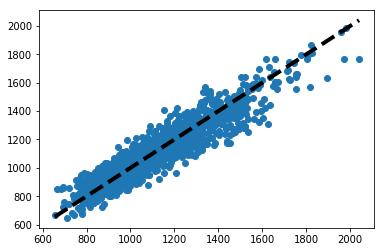

In [8]:
# Plotando o gráfico 

fig, ax = plt.subplots()
ax.scatter(teste_y, predicao_y)
ax.plot([teste_y.min(), teste_y.max()], [teste_y.min(), teste_y.max()], 'k--', lw = 4)
plt.show()